# Decomposition of the data:

### Decompostion models:
- Additive : Trend + Seasoality + Error
- Multiplicatve : Trend * Seasonality * Error

#### the seasonality on our data is almost have the same magintude we have chosen the additive model to decompose the data

## Decompostion Steps:
- Detrending the data:
    1. get the trend usnig Smoothing or Regresion models
    2. detrending the data by subtracting the  trend on the data from the observed ones
- Deseasonal the data:
    1. get the seasonality factor for every time stamp by taking the averages over the timestamp
    2. deaseasonalize the data by subtracting the seasonal factor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [123]:
from sklearn.preprocessing import PolynomialFeatures as poly

In [139]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [135]:
from scipy import signal

In [2]:
def get_hour(datetime_o):
    """
    this function to get the hour of the day to use it as an additional regressor
    """
    return datetime_o.hour
def get_min(datetime_o):
    """
    this function to get the hour of the day to use it as an additional regressor
    """
    return datetime_o.minute
def get_day(datetime_o):
    """
    this function to get the the day to use it as an additional regressor
    """
    return datetime_o.day
def get_weekday(datetime_o):
    """
    this function to get the the day of the week to use it as an additional regressor
    """
    return datetime_o.weekday()

In [3]:
df = pd.read_csv("final_data.csv")
df["time"] = pd.to_datetime(df["time"])
df.rename(columns = {"indernet_cdr": "internet_cdr"}, inplace = True)

In [4]:
df

,grid_square,internet_cdr,time
0,5056,517.607260,2013-11-01 00:00:00
1,5056,314.551305,2013-11-01 00:10:00
2,5056,341.527327,2013-11-01 00:20:00
3,5056,450.012415,2013-11-01 00:30:00
4,5056,312.166782,2013-11-01 00:40:00
...,...,...,...
80347,5258,153.632216,2014-01-01 23:10:00
80348,5258,125.178334,2014-01-01 23:20:00
80349,5258,104.560788,2014-01-01 23:30:00
80350,5258,132.476372,2014-01-01 23:40:00


In [161]:
df_f = df.groupby("grid_square")
groups = list(df_f.groups)
chosen_grids = [5056,5057,5058,5156,5157,5158,5256,5257,5258]
final_grid = pd.DataFrame()
seasonality = {}
for grid in chosen_grids:
    df1 = pd.DataFrame()
    #get the grid with the last 12 days excluded
    df_r = df_f.get_group(grid)[:-12*144]
    #### Detrending ########

    # 1-detrend by linear Regression
    LR = LinearRegression()
    LR.fit(np.array(df_r.index).reshape(-1,1), df_r["internet_cdr"])
    df_r["trend_LR"] = LR.predict((np.array(df_r.index).reshape(-1,1)))
    df_r["detrended_LR"] = df_r["internet_cdr"] - df_r["trend_LR"]
    
    #2- Detrend by smoothing:
    df_r["trend_smooth"]= df_r["internet_cdr"].rolling(window = 144, min_periods = 1).mean()
    df_r["detrended_smooth"] = df_r["internet_cdr"] - df_r["trend_smooth"]
    
    #3- Detrend By ploynimial
    p = poly(degree = 4, include_bias = False)
    p_inter = p.fit_transform(np.array(df_r.index).reshape(-1,1))
    LR1 = LinearRegression()
    LR1.fit(p_inter, df_r["internet_cdr"])
    df_r["trend_poly"] = LR1.predict(p_inter)
    df_r["detrended_poly"] = df_r["internet_cdr"] - df_r["trend_poly"]
    
    # 4- Getting seasonal features
    df_r["day_of_week"] = df_r["time"].apply(get_weekday)
    df_r["hour"] = df_r["time"].apply(get_hour)
    df_r["minute"] = df_r["time"].apply(get_min)
    
    # 5- getting seasonal factors:
    df_g = df_r.groupby(["day_of_week", "hour", "minute"])
    means_LR = df_g["detrended_LR"].mean()
    means_poly = df_g["detrended_poly"].mean()
    means_smooth = df_g["detrended_smooth"].mean()
    
    #saviing into seasonal dictionary
    seasonality[grid] = {"s_factors_LR":means_LR, "s_factors_poly":means_poly, "s_factors_smooth":means_smooth}
    time_stamps = list(df_g.groups)
    # 3- Decompose: 
    for ts in time_stamps:
        df_g1 = df_g.get_group(ts)
        #### Deseasonal the data #######
        #getting poper seasonal factors
        seasonal_factor_LR = means_LR[ts]
        seasonal_factor_poly = means_poly[ts]
        seasonal_factor_smooth = means_smooth[ts]
        
        #Deseasonlize the data
        df_g1["deseasonal_LR"] = df_g1["detrended_LR"] - seasonal_factor_LR
        df_g1["deseasonal_poly"] = df_g1["detrended_poly"] - seasonal_factor_LR
        df_g1["deseasonal_smooth"] = df_g1["detrended_smooth"] - seasonal_factor_LR
        df1 = pd.concat([df_g1,df1 ])
    # 4- Redordering the Data
    df1 = df1.sort_values("time")
    # Final DataFrame
    final_grid = pd.concat([final_grid, df1])

In [163]:
final_grid

,grid_square,internet_cdr,time,trend_LR,detrended_LR,trend_smooth,detrended_smooth,trend_poly,detrended_poly,day_of_week,hour,minute,deseasonal_LR,deseasonal_poly,deseasonal_smooth
0,5056,517.607260,2013-11-01 00:00:00,459.676063,57.931196,517.607260,0.000000,227.441726,290.165534,4,0,0,181.075380,413.309717,123.144183
1,5056,314.551305,2013-11-01 00:10:00,459.691715,-145.140410,416.079282,-101.527977,227.887907,86.663398,4,0,10,12.167975,243.971783,55.780408
2,5056,341.527327,2013-11-01 00:20:00,459.707367,-118.180040,391.228631,-49.701304,228.333695,113.193632,4,0,20,69.399172,300.772844,137.877908
3,5056,450.012415,2013-11-01 00:30:00,459.723019,-9.710604,405.924577,44.087839,228.779089,221.233326,4,0,30,182.528191,413.472121,236.326633
4,5056,312.166782,2013-11-01 00:40:00,459.738671,-147.571889,387.173018,-75.006236,229.224090,82.942692,4,0,40,64.387188,294.901769,136.952841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78619,5258,925.535544,2013-12-20 23:10:00,1846.210148,-920.674604,1896.964025,-971.428481,2088.199823,-1162.664279,4,23,10,-125.120843,-367.110518,-175.874720
78620,5258,769.307634,2013-12-20 23:20:00,1846.269637,-1076.962003,1897.065388,-1127.757755,2088.774771,-1319.467137,4,23,20,-247.913905,-490.419040,-298.709657
78621,5258,769.111522,2013-12-20 23:30:00,1846.329125,-1077.217603,1897.333079,-1128.221557,2089.350132,-1320.238610,4,23,30,-275.593735,-518.614741,-326.597688
78622,5258,741.301673,2013-12-20 23:40:00,1846.388614,-1105.086941,1897.347521,-1156.045848,2089.925905,-1348.624232,4,23,40,-309.514163,-553.051454,-360.473070


In [177]:
ee = pd.DataFrame(seasonality[5056]["s_factors_smooth"])

In [178]:
ee

detrended_smooth
day_of_week hour minute                  
0           0    0             -17.628768
                 10            -42.482285
                 20             -9.489269
                 30            -22.672474
                 40            -32.247479
...                                   ...
6           23   10             13.437278
                 20             31.782157
                 30              2.710268
                 40              9.877018
                 50             -5.640894

[1008 rows x 1 columns]

In [196]:
seasonal_factors = pd.DataFrame(columns = ["grid","s_factors_LR", "s_factors_poly", "s_factors_smooth"])
for grid in seasonality:
    g = [grid]*len(seasonality[grid]["s_factors_LR"].values)
    s_dict = {"grid": g}
    for s_factors in seasonality[grid]:
#         ee = pd,DataFrame(seasonality[grid][s_factors]).reset_index().
        s_dict[s_factors] = seasonality[grid][s_factors].values
    df_s = pd.DataFrame(s_dict)
    df_s = df_s.reset_index()
    print(df_s)
    dfs = df_s[["grid","s_factors_LR", "s_factors_poly","s_factors_smooth"]]
    seasonal_factors = pd.concat([seasonal_factors, dfs])

      index  grid  s_factors_LR  s_factors_poly  s_factors_smooth
0         0  5056   -276.292684     -276.260581        -17.628768
1         1  5056   -301.739350     -301.744336        -42.482285
2         2  5056   -269.067745     -269.109754         -9.489269
3         3  5056   -282.636576     -282.715545        -22.672474
4         4  5056   -292.418155     -292.534018        -32.247479
...     ...   ...           ...             ...               ...
1003   1003  5056   -242.698209     -242.479692         13.437278
1004   1004  5056   -224.853052     -224.671947         31.782157
1005   1005  5056   -254.430146     -254.286389          2.710268
1006   1006  5056   -247.718244     -247.611770          9.877018
1007   1007  5056   -263.779393     -263.710137         -5.640894

[1008 rows x 5 columns]
      index  grid  s_factors_LR  s_factors_poly  s_factors_smooth
0         0  5057   -368.883794     -366.149967        -89.962134
1         1  5057   -352.075687     -349.364544    

In [197]:
seasonal_factors = seasonal_factors.reset_index()

In [199]:
seasonal_factors.drop(columns = ["index"], inplace = True)

In [200]:
seasonal_factors

,grid,s_factors_LR,s_factors_poly,s_factors_smooth
0,5056,-276.292684,-276.260581,-17.628768
1,5056,-301.739350,-301.744336,-42.482285
2,5056,-269.067745,-269.109754,-9.489269
3,5056,-282.636576,-282.715545,-22.672474
4,5056,-292.418155,-292.534018,-32.247479
...,...,...,...,...
9067,5258,-1278.397488,-1268.718266,-359.686269
9068,5258,-1325.557897,-1315.968361,-402.316192
9069,5258,-1321.918604,-1312.418713,-394.202194
9070,5258,-1334.192904,-1324.782619,-402.197373


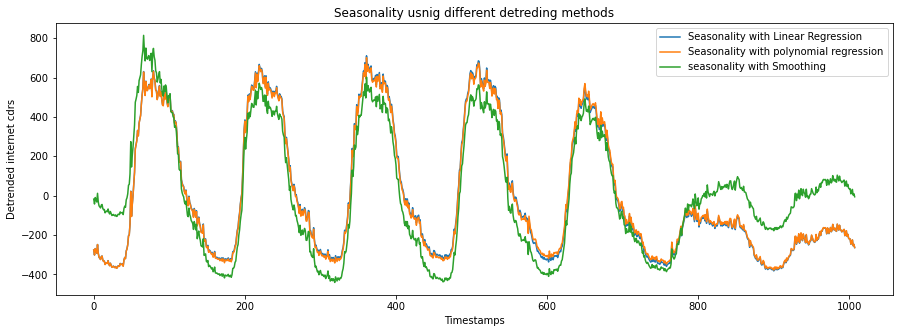

In [203]:
plt.figure(figsize = (15,5))
plt.title("Seasonality usnig different detreding methods")
plt.xlabel("Timestamps")
plt.ylabel("Detrended internet cdrs")
plt.plot(seasonal_factors[seasonal_factors["grid"] == 5056]["s_factors_LR"], label ="Seasonality with Linear Regression")
plt.plot(seasonal_factors[seasonal_factors["grid"] == 5056]["s_factors_poly"], label = "Seasonality with polynomial regression")
plt.plot(seasonal_factors[seasonal_factors["grid"] == 5056]["s_factors_smooth"], label ="seasonality with Smoothing" )
plt.legend()
plt.show()

Here we can see that the smoothing method has extracted the trend better than the regression models, and both regression models has almost identical results so there is no need for it, the smoothing has bring the data to be around the zero wich indicates that it captured the data very well.

But it has some disadventage in the first day because it in the fisrst the smooting don't have the ability to capture trend well because there is no enough data for the window whose size is 144(Day Observations).

In [204]:
plotting = final_grid.groupby("grid_square")

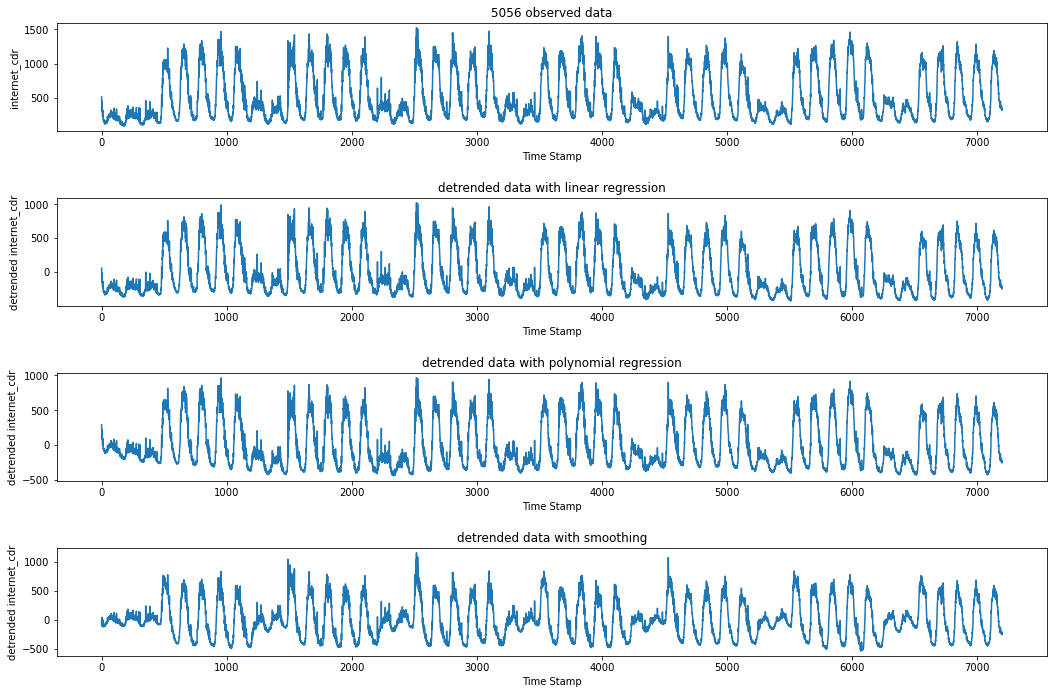

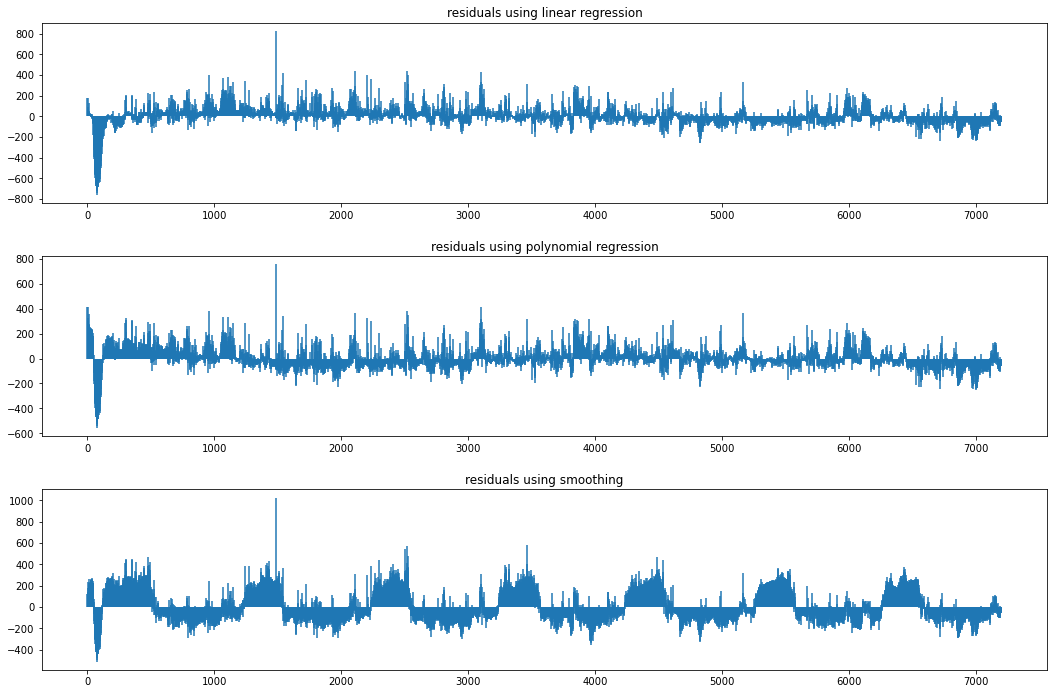

In [220]:
for grid in chosen_grids[:1]:
    p = plotting.get_group(grid)
    fig, axs = plt.subplots(4,1, figsize = (15,10))
    axs[0].plot(p["internet_cdr"], label = "Observed Data")
    axs[0].set_xlabel("Time Stamp")
    axs[0].set_ylabel("internet_cdr")
    axs[0].set_title("{} observed data".format(grid))
    
    axs[1].plot(p["detrended_LR"], label = "detrended data with linear regression")
    axs[1].set_xlabel("Time Stamp")
    axs[1].set_ylabel("detrended internet_cdr")
    axs[1].set_title("detrended data with linear regression")
    
    axs[2].plot(p["detrended_poly"], label = "detrended data with polynomial regression")
    axs[2].set_xlabel("Time Stamp")
    axs[2].set_ylabel("detrended internet_cdr")
    axs[2].set_title("detrended data with polynomial regression")
    
    axs[3].plot(p["detrended_smooth"], label = "detrended data with smoothing")
    axs[3].set_xlabel("Time Stamp")
    axs[3].set_ylabel("detrended internet_cdr")
    axs[3].set_title("detrended data with smoothing")
    
    plt.tight_layout(pad = 2)
    
    
    fig2, axs2 = plt.subplots(3,1, figsize = (15,10))
    
    
    axs2[0].vlines(list(p["internet_cdr"].index),[0]*len(p), p["deseasonal_LR"])
    axs2[0].set_title("residuals using linear regression")
    
    axs2[1].vlines(list(p["internet_cdr"].index),[0]*len(p), p["deseasonal_poly"])
    axs2[1].set_title("residuals using polynomial regression")
    
    axs2[2].vlines(list(p["internet_cdr"].index),[0]*len(p), p["deseasonal_smooth"])
    axs2[2].set_title("residuals using smoothing")
    
    
    plt.tight_layout(pad = 2)
    plt.show()

In [207]:
final_grid.to_csv("Decomposed_grids.csv", index = False)
seasonal_factors.to_csv("seasonal_factors.csv", index = False)

# Detreding using Smoothing:

In [66]:
df_tr = df_f.get_group(5058)

In [67]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 17856 to 26783
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   grid_square   8928 non-null   int64         
 1   internet_cdr  8928 non-null   float64       
 2   time          8928 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 279.0 KB


In [68]:
df_tr

,grid_square,internet_cdr,time
17856,5058,668.180795,2013-11-01 00:00:00
17857,5058,749.816592,2013-11-01 00:10:00
17858,5058,671.254568,2013-11-01 00:20:00
17859,5058,854.241603,2013-11-01 00:30:00
17860,5058,597.638167,2013-11-01 00:40:00
...,...,...,...
26779,5058,395.735530,2014-01-01 23:10:00
26780,5058,252.661642,2014-01-01 23:20:00
26781,5058,380.242311,2014-01-01 23:30:00
26782,5058,408.882175,2014-01-01 23:40:00


In [69]:
df_tr = df_tr.reset_index()

In [236]:
df_tr["trend_smoothed"]= df_tr["internet_cdr"].rolling(window = 432, min_periods = 1).mean()

<AxesSubplot:>

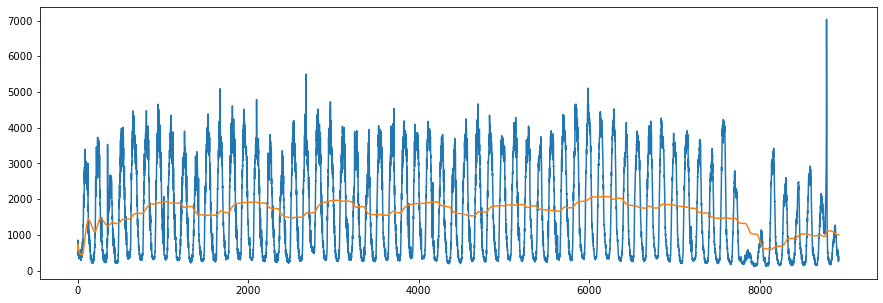

In [237]:
plt.figure(figsize = (15,5))
df_tr["internet_cdr"].plot()
df_tr["trend_smoothed"].plot()

# Using polynomial regression:

In [124]:
p = poly(degree = 4, include_bias = False)

In [125]:
p_inter = p.fit_transform(np.array(df_tr.index).reshape(-1,1))

In [126]:
p_inter

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00000000e+00, 4.00000000e+00, 8.00000000e+00, 1.60000000e+01],
       ...,
       [8.92500000e+03, 7.96556250e+07, 7.10926453e+11, 6.34501859e+15],
       [8.92600000e+03, 7.96734760e+07, 7.11165447e+11, 6.34786278e+15],
       [8.92700000e+03, 7.96913290e+07, 7.11404494e+11, 6.35070792e+15]])

In [127]:
LR1 = LinearRegression()

In [128]:
df_tr["internet_cdr"]

0       668.180795
1       749.816592
2       671.254568
3       854.241603
4       597.638167
           ...    
8923    395.735530
8924    252.661642
8925    380.242311
8926    408.882175
8927    291.945573
Name: internet_cdr, Length: 8928, dtype: float64

In [129]:
LR1.fit(p_inter, df_tr["internet_cdr"])

LinearRegression()

In [130]:
tren = LR1.predict(p_inter)

In [131]:
tren

array([1457.51494086, 1457.78899408, 1458.06285769, ...,  574.62111343,
        573.74182698,  572.86207699])

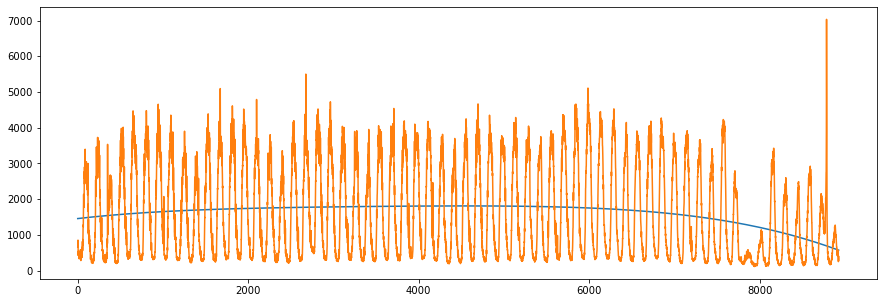

In [132]:
plt.figure(figsize = (15,5))
plt.plot(tren)
plt.plot(df_tr["internet_cdr"])

# Using Scipy detrend:

In [140]:
detrended = signal.detrend(df_tr["internet_cdr"])

In [143]:
trend1 = df_tr["internet_cdr"] - detrended

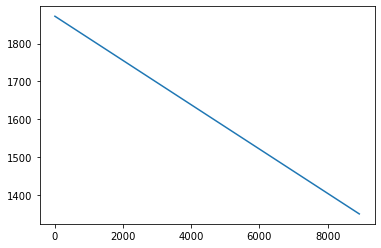

In [145]:
plt.plot(trend1)